<div align='center' ><img src='https://raw.githubusercontent.com/davidrpugh/numerical-methods/master/images/sgpe-logo.jpg' width="1200" height="100"></div>
<div align='right'><img src='https://raw.githubusercontent.com/davidrpugh/numerical-methods/master/images/SIRElogolweb.jpg' width="1200" height="100"></div>

In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sympy as sym
sym.init_printing() 
import solowpy

# 6. Calibration:

In this task we will look at a simple strategy for calibrating a Solow model with Cobb-Douglas production using data from the [Penn World Tables (PWT)](http://www.rug.nl/research/ggdc/data/penn-world-table).

### Capital depreciation rate, $\delta$: 
The PWT provides estimated depreciation rates that vary across both time and countries. As an estimate for the rate of capital depreciation for country $i$ I use the time-average of $\verb|delta_k|_{it}$ as provided by the PWT. 

### Capital's share of output/income, $\alpha$: 
Capital's share for country $i$ in year $t$, $\alpha_{it}$ is computed as $\alpha_{it} = 1 - \verb|labsh|_{it}$, where $\verb|labsh|_{it}$ is the labor share of output/income for country $i$ in year $t$ provided by the PWT. I then use the time-average of $\alpha_{it}$ as the estimate of capital's share for country $i$.

### Savings rate, $s$: 
As a measure of the savings rate for country $i$, I take the simple time-average of the annual investment share of real GDP, $\verb|i_sh|$, for country $i$ from the PWT.

### Labor force growth rate, $n$:
To obtain a measure of the labor force growth rate for country $i$, I regress the logarithm of total employed persons, $\verb|emp|$, in country $i$ from the PWT on a constant and a linear time trend.

$$ \ln\ \verb|emp|_i = \beta_0 + \beta_1 \verb|t| + \epsilon_i \tag{2.1}$$

The estimated coefficient $\beta_1$ is then used as my estimate for the $n$. To estimate the initial number of employed persons, $L_0$, I use $e^{\beta_0}$ as the estimate for $L_0$.

### Growth rate of technology, $g$:
To obtain a measure of the growth rate of technology for country $i$, I first adjust the total factor productivity measure reported by the PWT, $\verb|rtfpna|$ (which excludes the human capital contribution to TFP), and then regress the logarithm of this adjusted measure of TFP, $\verb|atfpna|$, for country $i$ on a constant and a linear time trend.

$$ \ln\ \verb|atfpna|_i = \beta_0 + \beta_1 \verb|t| + \epsilon_i \tag{2.2}$$

The estimated coefficient $\beta_1$ is then used as my estimate for the $g$. To estimate the initial level of technology, $A_0$, I use $e^{\beta_0}$ as the estimate for $A_0$.

All of this is being done "behind the scenes".  All you need to in order to calibrate the model is pick an [ISO 3 country code](http://en.wikipedia.org/wiki/ISO_3166-1_alpha-3)! Now let's calibrate a Solow model for the UK.

In [4]:
import pypwt

In [12]:
#pwt = pypwt.load_pwt_data()

from __future__ import division
from io import BytesIO
import zipfile

import pandas as pd
import requests

#pwt changes url, pypwt does not working
#use pandas load pwt data

## Depreciation rate
base_url = 'http://www.rug.nl/ggdc/docs'
version=90
tmp_url = base_url + '/depreciation_rates.zip'
tmp_buffer = requests.get(url=tmp_url)
tmp_zip = zipfile.ZipFile(BytesIO(tmp_buffer.content))
tmp_zip.extract('depreciation_rates.dta')

## pwt table 90
tmp_url = base_url + '/pwt' + str(version) + '.dta'
tmp_buffer = requests.get(url=tmp_url)

pwt_raw_data = pd.read_stata( base_url + '/pwt' + str(version) + '.dta')
dep_rates_raw_data = pd.read_stata('depreciation_rates.dta')


####### straite forward way
#pwt_raw_data = pd.read_stata('http://www.rug.nl/ggdc/docs/pwt90.dta')
#dep_rates_raw_data = pd.read_excel('http://www.rug.nl/ggdc/docs/depreciation_rates.xlsx', )

# merge the data
pwt_merged_data = pd.merge(pwt_raw_data, dep_rates_raw_data, how='outer',
                           on=['countrycode', 'year'])

# create the hierarchical index
pwt_merged_data.year = pd.to_datetime(pwt_raw_data.year, format='%Y')
pwt_merged_data.set_index(['countrycode', 'year'], inplace=True)

# coerce into a panel
pwt_panel_data = pwt_merged_data.to_panel()

pwt = pwt_panel_data

In [13]:
pwt_merged_data.tail()

country currency_unit         rgdpe         rgdpo  \
countrycode year                                                             
ZWE         2010-01-01  Zimbabwe     US Dollar  20652.718750  21053.855469   
            2011-01-01  Zimbabwe     US Dollar  20720.435547  21592.298828   
            2012-01-01  Zimbabwe     US Dollar  23708.654297  24360.527344   
            2013-01-01  Zimbabwe     US Dollar  27011.988281  28157.886719   
            2014-01-01  Zimbabwe     US Dollar  28495.554688  29149.708984   

                              pop       emp  avh        hc          ccon  \
countrycode year                                                           
ZWE         2010-01-01  13.973897  6.298438  NaN  2.372605  21862.835938   
            2011-01-01  14.255592  6.518841  NaN  2.415823  26202.080078   
            2012-01-01  14.565482  6.248271  NaN  2.459828  30321.824219   
            2013-01-01  14.898092  6.287056  NaN  2.504635  32283.355469   
            2014-01-01  15.245855  6.499974  NaN  2.550258  32038.916016   

                                 cda    ...        csh_x     csh_m     csh_r  \
countrycode year                        ...                                    
ZWE         2010-01-01  26023.046875    ...     0.214657 -0.454497  0.014462   
            2011-01-01  30250.195312    ...     0.219809 -0.625170  0.004390   
            2012-01-01  32171.179688    ...     0.225631 -0.479897 -0.076998   
            2013-01-01  35336.441406    ...     0.174443 -0.436145 -0.000005   
            2014-01-01  35454.808594    ...     0.147346 -0.349806 -0.020068   

                            pl_c      pl_i      pl_g      pl_x      pl_m  \
countrycode year                                                           
ZWE         2010-01-01  0.447170  0.543100  0.411316  0.701797  0.606324   
            2011-01-01  0.531029  0.606065  0.440252  0.739989  0.637035   
            2012-01-01  0.474047  1.363167  0.458315  0.712036  0.634858   
            2013-01-01  0.498061  0.575870  0.465031  0.717884  0.630712   
            2014-01-01  0.528013  0.550110  0.464699  0.716963  0.628869   

                            pl_k   delta_k  
countrycode year                            
ZWE         2010-01-01  1.015145  0.036048  
            2011-01-01  0.470333  0.036279  
            2012-01-01  0.608320       NaN  
            2013-01-01  0.414526       NaN  
            2014-01-01  0.386039       NaN  

[5 rows x 46 columns]

In [14]:
pwt_merged_data.columns

Index([u'country', u'currency_unit', u'rgdpe', u'rgdpo', u'pop', u'emp',
       u'avh', u'hc', u'ccon', u'cda', u'cgdpe', u'cgdpo', u'ck', u'ctfp',
       u'cwtfp', u'rgdpna', u'rconna', u'rdana', u'rkna', u'rtfpna',
       u'rwtfpna', u'labsh', u'delta', u'xr', u'pl_con', u'pl_da', u'pl_gdpo',
       u'i_cig', u'i_xm', u'i_xr', u'i_outlier', u'cor_exp', u'statcap',
       u'csh_c', u'csh_i', u'csh_g', u'csh_x', u'csh_m', u'csh_r', u'pl_c',
       u'pl_i', u'pl_g', u'pl_x', u'pl_m', u'pl_k', u'delta_k'],
      dtype='object')

In [38]:
pwt

<class 'pandas.core.panel.Panel'>
Dimensions: 46 (items) x 182 (major_axis) x 65 (minor_axis)
Items axis: country to delta_k
Major_axis axis: ABW to ZWE
Minor_axis axis: 1950-01-01 00:00:00 to 2014-01-01 00:00:00

In [42]:
pwt.loc[:,:,'1980-01-01':'2014-01-01']

<class 'pandas.core.panel.Panel'>
Dimensions: 46 (items) x 182 (major_axis) x 35 (minor_axis)
Items axis: country to delta_k
Major_axis axis: ABW to ZWE
Minor_axis axis: 1980-01-01 00:00:00 to 2014-01-01 00:00:00

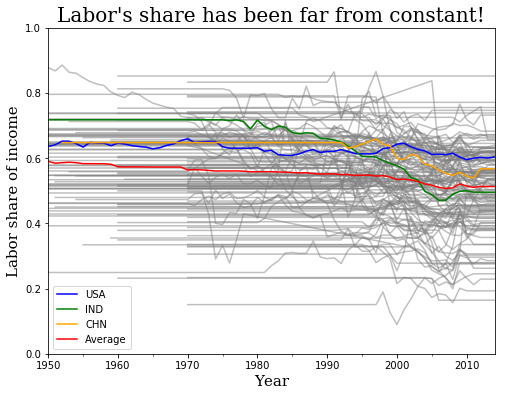

In [47]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.major_axis:
    tmp_data = pwt.major_xs(ctry)
    tmp_data.labsh.plot(color='gray', alpha=0.5, label= '_nolegend_')
    
# plot some specific countries
pwt.major_xs('USA').labsh.plot(color='blue', ax=ax, label='USA')
pwt.major_xs('IND').labsh.plot(color='green', ax=ax, label='IND')
pwt.major_xs('CHN').labsh.plot(color='orange', ax=ax, label='CHN')

# plot global average
avg_labor_share = pwt.labsh.mean(axis=0)
avg_labor_share.plot(color='r', ax=ax, label = 'Average')

ax.set_title("Labor's share has been far from constant!",
             fontsize=20, family='serif')
ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('Labor share of income', family='serif', fontsize=15)
ax.set_ylim(0, 1)


# Create  legend 
plt.legend()

plt.show()

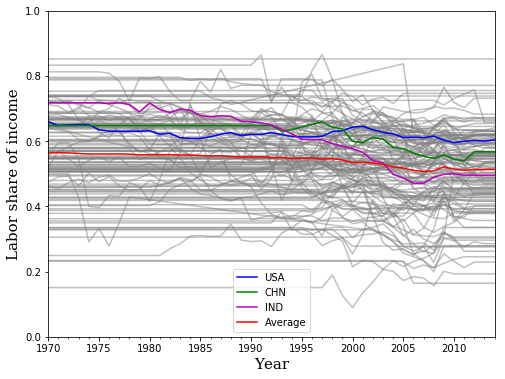

In [48]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.loc[:,:,'1970-01-01':'2014-01-01'].major_axis:
    tmp_data = pwt.loc[:,:,'1970-01-01':'2014-01-01'].major_xs(ctry)
    tmp_data.labsh.plot(color='gray', alpha=0.5, label= '_nolegend_')
    
# plot some specific countries
pwt.loc[:,:,'1970-01-01':'2014-01-01'].major_xs('USA').labsh.plot(color='b', ax=ax, label='USA')
pwt.loc[:,:,'1970-01-01':'2014-01-01'].major_xs('CHN').labsh.plot(color='g', ax=ax, label='CHN')
pwt.loc[:,:,'1970-01-01':'2014-01-01'].major_xs('IND').labsh.plot(color='M', ax=ax, label='IND')

# plot global average
avg_labor_share = pwt.loc[:,:,'1970-01-01':'2014-01-01'].labsh.mean(axis=0)
avg_labor_share.plot(color='r', ax=ax, label = 'Average')

ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('Labor share of income', family='serif', fontsize=15)
ax.set_ylim(0, 1)

# Create  legend 
plt.legend()

plt.show()

In [21]:
pwt.major_xs('USA').tail()

,country,currency_unit,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_k,delta_k
year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,United States,US Dollar,15368666.0,15250698.0,309.876170,141.349106,1738.000934,3.701753,12764841.0,15842214.0,...,0.114981,-0.160320,0.008117,0.945008,0.894477,1.280993,0.727769,0.780926,0.979772,0.039447
2011-01-01,United States,US Dollar,15590957.0,15517930.0,312.390368,142.217453,1755.294620,3.707011,13049097.0,16173676.0,...,0.124832,-0.176362,0.009272,0.962695,0.921007,1.300825,0.764881,0.805898,1.000000,0.039092
2012-01-01,United States,US Dollar,15976742.0,15899255.0,314.799465,144.862839,1753.699482,3.712276,13206454.0,16505245.0,...,0.127474,-0.178049,0.010143,0.979232,0.947662,1.324070,0.763976,0.805251,1.018421,NaN
2013-01-01,United States,US Dollar,16274530.0,16183547.0,317.135919,146.210968,1758.692633,3.717549,13356571.0,16668950.0,...,0.127341,-0.173468,0.010798,0.992369,0.983372,1.343849,0.769478,0.811322,1.035022,NaN
2014-01-01,United States,US Dollar,16704698.0,16598099.0,319.448634,148.463394,1764.596955,3.722829,13685949.0,17113208.0,...,0.127690,-0.176743,0.011316,1.003853,1.008345,1.370249,0.769208,0.804912,1.052024,NaN


In [22]:
pwt.major_xs('CHN').tail()

,country,currency_unit,rgdpe,rgdpo,pop,emp,avh,hc,ccon,cda,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_k,delta_k
year,,,,,,,,,,,,,,,,,,,,,
2010-01-01,China,Yuan Renminbi,12680616.0,12590990.0,1340.968737,781.376770,NaN,2.341955,6261514.5,12236486.0,...,0.179332,-0.151843,0.006767,0.478398,0.474673,0.450623,0.694366,0.725597,0.388634,0.030752
2011-01-01,China,Yuan Renminbi,13758196.0,13779918.0,1348.174478,784.426941,NaN,2.373193,6906203.5,13423772.0,...,0.186314,-0.163948,0.003479,0.535879,0.540434,0.556832,0.739424,0.771688,0.430163,0.030957
2012-01-01,China,Yuan Renminbi,14834279.0,14888096.0,1355.386952,788.870789,NaN,2.404846,7434364.0,14343898.0,...,0.189268,-0.158233,0.000152,0.572350,0.569502,0.597881,0.731126,0.776102,0.450013,NaN
2013-01-01,China,Yuan Renminbi,15904816.0,15878105.0,1362.514260,793.022278,NaN,2.436922,7901773.5,15265150.0,...,0.191392,-0.164606,-0.002537,0.607970,0.600979,0.634212,0.737756,0.757226,0.459550,NaN
2014-01-01,China,Yuan Renminbi,17080304.0,17135952.0,1369.435670,798.367798,NaN,2.469426,8443372.0,16302829.0,...,0.187983,-0.148360,-0.009438,0.628948,0.608447,0.653158,0.741235,0.785104,0.452994,NaN


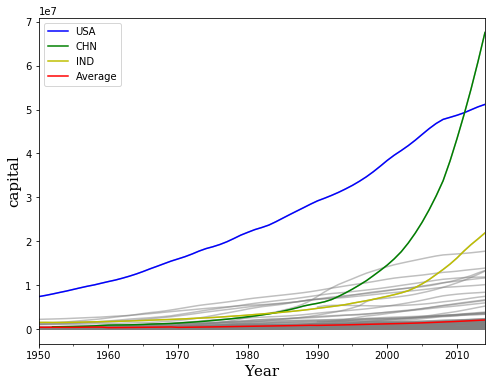

In [36]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.major_axis:
    tmp_data = pwt.major_xs(ctry)
    tmp_data.rkna.plot(color='gray', alpha=0.5, label= '_nolegend_')
    
# plot some specific countries
pwt.major_xs('USA').rkna.plot(color='b', ax=ax, label='USA')
pwt.major_xs('CHN').rkna.plot(color='g', ax=ax, label='CHN')
pwt.major_xs('IND').rkna.plot(color='y', ax=ax, label='IND')
# plot global average
avg_output_share = pwt.rkna.mean(axis=0)
avg_output_share.plot(color='r', ax=ax, label = 'Average')

ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('capital', family='serif', fontsize=15)
#ax.set_ylim(0, 1)

# Create  legend 
plt.legend()

plt.show()

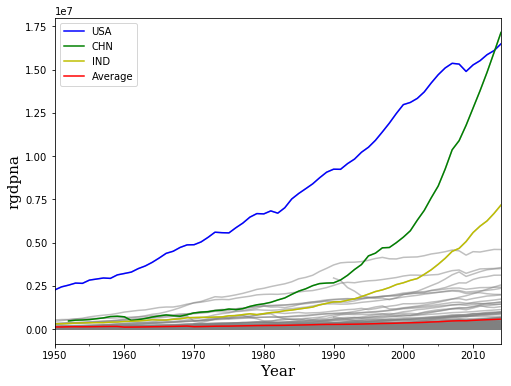

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.major_axis:
    tmp_data = pwt.major_xs(ctry)
    tmp_data.rgdpna.plot(color='gray', alpha=0.5, label= '_nolegend_')
    
# plot some specific countries
pwt.major_xs('USA').rgdpna.plot(color='b', ax=ax, label='USA')
pwt.major_xs('CHN').rgdpna.plot(color='g', ax=ax, label='CHN')
pwt.major_xs('IND').rgdpna.plot(color='y', ax=ax, label='IND')
# plot global average
avg_rgdpna_share = pwt.rgdpna.mean(axis=0)
avg_rgdpna_share.plot(color='r', ax=ax, label = 'Average')

ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('rgdpna', family='serif', fontsize=15)
#ax.set_ylim(0, 1)

# Create  legend 
plt.legend()

plt.show()

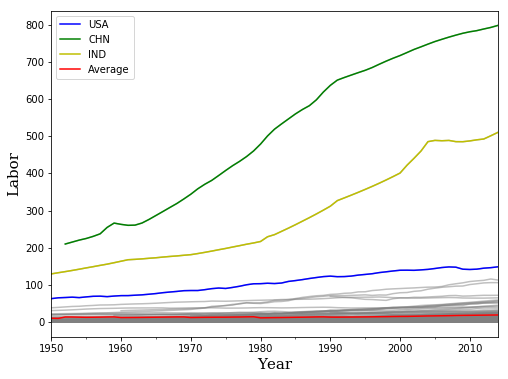

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

for ctry in pwt.major_axis:
    tmp_data = pwt.major_xs(ctry)
    tmp_data.emp.plot(color='gray', alpha=0.5, label= '_nolegend_')
    
# plot some specific countries
pwt.major_xs('USA').emp.plot(color='b', ax=ax, label='USA')
pwt.major_xs('CHN').emp.plot(color='g', ax=ax, label='CHN')
pwt.major_xs('IND').emp.plot(color='y', ax=ax, label='IND')
# plot global average
avg_emp_share = pwt.emp.mean(axis=0)
avg_emp_share.plot(color='r', ax=ax, label = 'Average')

ax.set_xlabel('Year', family='serif', fontsize=15)
ax.set_ylabel('Labor', family='serif', fontsize=15)
#ax.set_ylim(0, 1)

# Create  legend 
plt.legend()

plt.show()

In [15]:
def match_moments(model, data, iso3_code, bounds=None):
    r"""
    Simple calibration scheme for a Solow model with Cobb-Douglas production
    based on data from the Penn World Tables (PWT).

    Parameters
    ----------

    model : solow.CobbDouglasModel
        An instance of the CobbDouglasModel class that you wish to calibrate.
    data : pandas.Panel
        An instance of the pandas.Panel class containing PWT data.
    iso3_code : str
        A valid ISO3 country code. For example, to calibrate the model using
        data for the United States, one would set iso3_code='USA'; to calibrate
        a model using data for Zimbabwe, one would set iso3_code='ZWE'. For a
        complete listing of ISO3 country codes see `wikipedia`_.
    bounds : tuple (default=None)
        Start and end years for the subset of the PWT data to use for
        calibration. Note that start and end years should be specified as
        strings. For example, to calibrate a model using data from 1983 to 2003
        one would set

            bounds=('1983', '2003')

        By default calibration will make use of all available data for the
        specified country.

    .. `wikipedia`: http://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

    """
    # get the PWT data for the iso_code
    tmp_data = data.major_xs(iso3_code)
    required_vars = ['rgdpna', 'rkna', 'emp', 'labsh', 'csh_i', 'delta_k']
    tmp_data = tmp_data[required_vars].dropna()
    assert not tmp_data.empty, "Insufficient data to estimate model parameters"
    
    # set bounds
    if bounds is None:
        start = tmp_data.index[0]
        end = tmp_data.index[-1]
    else:
        start = bounds[0]
        end = bounds[1]
    tmp_data = tmp_data.loc[start:end]

    # define the data used in the calibration
    output = tmp_data['rgdpna']
    capital = tmp_data['rkna']
    labor = tmp_data['emp']
    labor_share = tmp_data['labsh']
    savings_rate = tmp_data['csh_i']
    depreciation_rate = tmp_data['delta_k']

    # define a time trend variable
    N = tmp_data.index.size
    linear_trend = pd.Series(np.linspace(0, N - 1, N), index=tmp_data.index)
    time_trend = linear_trend.loc[start:end]

    # estimate capital's share of income/output
    capital_share = 1 - labor_share
    alpha = capital_share.mean()

    # compute solow residual (note dependence on alpha!)
    solow_residual = model.evaluate_solow_residual(output, capital, labor)
    technology = solow_residual.loc[start:end]

    # estimate the fraction of output saved
    s = savings_rate.mean()

    # regress log employed persons on linear time trend
    res = pd.ols(y=np.log(labor), x=time_trend)
    n = res.beta[0]
    L0 = np.exp(res.beta[1])

    # regress log TFP on linear time trend
    res = pd.ols(y=np.log(technology), x=time_trend)
    g = res.beta[0]
    A0 = np.exp(res.beta[1])

    # estimate the depreciation rate for total capital
    delta = depreciation_rate.mean()

    # create a dictionary of model parameters
    tmp_params = {'s': s, 'alpha': alpha, 'delta': delta, 'n': n, 'L0': L0,
                  'g': g, 'A0': A0}

    # update the model's parameters
    return tmp_params


In [17]:
# define model parameters
cobb_douglas_params = {'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
                      'delta': 0.05, 'alpha': 0.33}

# create an instance of the solow.Model class
cobb_douglas_model = solowpy.CobbDouglasModel(params=cobb_douglas_params)

In [18]:
match_moments(cobb_douglas_model, pwt, 'CHN')

{'A0': 1572.2692120145859,
 'L0': 229.07329692019235,
 'alpha': 0.3681475818157196,
 'delta': 0.029869206249713898,
 'g': 0.02337034981826255,
 'n': 0.024449857029560915,
 's': 0.20134255290031433}

# Estimating model with CES production

## Maximum likelihood

In [50]:
# define model parameters
ces_params = {'K0': 1.0, 'A0': 1.0, 'L0': 1.0, 'g': 0.02, 'n': 0.03, 's': 0.15,
              'delta': 0.05, 'alpha': 0.33, 'sigma': 0.95, 'sigma_eps': 0.01}

# create an instance of the solow.Model class
ces_model = solowpy.CESModel(params=ces_params)

In [51]:
from scipy import optimize, stats

In [52]:
def _intialize_labor_supply(model, labor):
    """Initial condition for labor supply is not a free parameter."""
    
    
def _cobb_douglas_initial_guess(model, data, iso3_code, bounds, sigma0, sigma_eps0):
    """Estimate parameters assumming Cobb Douglas production."""
    tmp_params = match_moments(model, data, iso3_code, bounds)
    
    # initial guesses for sigma, and sigma_eps
    tmp_params['sigma'] = sigma0
    tmp_params['sigma_eps'] = sigma_eps0
    
    return _params_to_array(tmp_params) 

def _array_to_params(array):
    """Converts array to dictionary of model params."""
    keys = ['g', 'n', 's', 'alpha', 'delta', 'sigma', 'sigma_eps']
    params = dict(zip(keys, array))
    return params

def _params_to_array(params):
    """Converts dictionary of model params to an array."""
    g = params['g']
    n = params['n']
    s = params['s']
    alpha = params['alpha']
    delta = params['delta']
    sigma = params['sigma']
    sigma_eps = params['sigma_eps']
    return np.array([g, n, s, alpha, delta, sigma, sigma_eps])
    
def _likelihood_function(params_array, model, output, capital, labor, labor_share):
    """Objective for maximum likelihood estimation."""
    # create tmp parameter dictionary
    tmp_params = model.params.copy()
    new_params = _array_to_params(params_array)
    tmp_params.update(new_params)
    model.params = tmp_params

    # compute solow residual (note dependence on alpha and sigma!)
    technology = model.evaluate_solow_residual(output, capital, labor)
    
    # compute capital (per unit effective labor)
    k = capital / (technology * labor)

    # model predicted labor's share of income/output
    predicted_labor_share = 1 - model.evaluate_output_elasticity(k)

    # residual difference between model predictions and data
    residual = labor_share - predicted_labor_share

    # assumes residuals are gaussian
    total_log_likelihood = np.sum(np.log(stats.norm.pdf(residual, 0, model.params['sigma_eps'])))

    return -total_log_likelihood

In [53]:
def maximize_likelihood(model, data, iso3_code, bounds=None, method='BFGS', sigma0=1.01, sigma_eps0=0.01):
    r"""
    Maximum likelihood estimation scheme for a Solow model with CES
    production based on data from the Penn World Tables (PWT).

    Parameters
    ----------

    model : solow.CESModel
        An instance of the CESModel class that you wish to estimate.
    data : pandas.Panel
        An instance of the pandas.Panel class containing PWT data.
    iso3_code : str
        A valid ISO3 country code. For example, to calibrate the model using
        data for the United States, one would set iso3_code='USA'; to calibrate
        a model using data for Zimbabwe, one would set iso3_code='ZWE'. For a
        complete listing of ISO3 country codes see `wikipedia`_.
    bounds : tuple (default=None)
        Start and end years for the subset of the PWT data to use for
        calibration. Note that start and end years should be specified as
        strings. For example, to calibrate a model using data from 1983 to 2003
        one would set

            bounds=('1983', '2003')

        By default calibration will make use of all available data for the
        specified country.

    .. `wikipedia`: http://en.wikipedia.org/wiki/ISO_3166-1_alpha-3

    """
    # get the PWT data for the iso_code
    tmp_data = data.major_xs(iso3_code)
    required_vars = ['rgdpna', 'rkna', 'emp', 'labsh']
    tmp_data = tmp_data[required_vars].dropna()
    assert not tmp_data.empty, "Insufficient data to estimate model parameters"
    
    # set bounds
    if bounds is None:
        start = tmp_data.index[0]
        end = tmp_data.index[-1]
    else:
        start = bounds[0]
        end = bounds[1]
    tmp_data = tmp_data.loc[start:end]

    # define the data used in the calibration
    output = tmp_data['rgdpna'].loc[start:end]
    capital = tmp_data['rkna'].loc[start:end]
    labor = tmp_data['emp'].loc[start:end]
    labor_share = tmp_data['labsh'].loc[start:end]
    technology = model.evaluate_solow_residual(output, capital, labor)

    initial_guess = _cobb_douglas_initial_guess(model, data, iso3_code, bounds,
                                                sigma0, sigma_eps0)
    
    eps = 1e-6
    bnds = [(None, None), (None, None), (eps, 1-eps), (eps, 1-eps),
            (eps, None), (eps, None), (eps, None)]
    result = optimize.minimize(_likelihood_function,
                               x0=initial_guess,
                               args=(model, output, capital, labor, labor_share),
                               method=method,
                               bounds=bnds)
    if result.success:
        tmp_params = _array_to_params(result.x)
        tmp_params['A0'] = technology[0]
        tmp_params['L0'] = labor[0]
        tmp_params['K0'] = capital[0]
    
        return result, tmp_params
    
    else:
        return result

In [54]:
# Add assertion error to evaluate solow_residual method@
result, params = maximize_likelihood(ces_model, pwt, 'USA', bounds=(None, None),
                                     method='Nelder-Mead', sigma0=0.5, sigma_eps0=0.01)

In [55]:
result

 final_simplex: (array([[ 0.01610019,  0.0136199 ,  0.13042943,  0.53035283,  0.0210371 ,
         0.76517805,  0.01530127],
       [ 0.01609985,  0.0136202 ,  0.13042073,  0.53033859,  0.02103877,
         0.76518842,  0.01530136],
       [ 0.01610022,  0.01361844,  0.13044709,  0.53030154,  0.0210437 ,
         0.76522545,  0.01529955],
       [ 0.01609954,  0.01361953,  0.13042947,  0.53029608,  0.02104417,
         0.76523138,  0.01530018],
       [ 0.01610029,  0.01361878,  0.13044426,  0.5303143 ,  0.02104213,
         0.76521068,  0.01529991],
       [ 0.01610244,  0.01361807,  0.130495  ,  0.53039114,  0.02103389,
         0.76513888,  0.01529915],
       [ 0.01610203,  0.01361848,  0.13048888,  0.53037664,  0.02103561,
         0.76515284,  0.01529912],
       [ 0.01610168,  0.01361831,  0.13047047,  0.53037611,  0.02103498,
         0.76515357,  0.01529998]]), array([-179.45986343, -179.4598568 , -179.45984291, -179.45983912,
       -179.45983467, -179.45982138, -179.45981957

In [56]:
ces_model.params = params

In [58]:
params

{'A0': 32919.625,
 'K0': 15973746.0,
 'L0': 84.698349,
 'alpha': 0.5303528310014034,
 'delta': 0.021037095718989478,
 'g': 0.016100192747490215,
 'n': 0.013619902831091889,
 's': 0.13042942722247489,
 'sigma': 0.76517805346793244,
 'sigma_eps': 0.015301268337946629}

In [59]:
def _initial_condition(model):
    k0 = model.params['K0'] / (model.params['A0'] * model.params['L0'])
    return k0

# need to specify some initial conditions
t0, k0 = 0.0, _initial_condition(ces_model)
numeric_soln = ces_model.ivp.solve(t0, k0, T=62, integrator='dopri5')

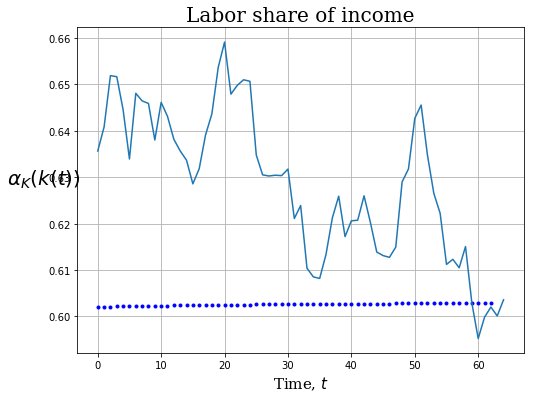

In [60]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(numeric_soln[:,0], 1 - ces_model.evaluate_output_elasticity(numeric_soln[:,1]),
        'bo', markersize=3.0)

ax.plot(pwt.major_xs('USA').labsh.loc[:].values)

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel(r'$\alpha_K(k(t))$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Labor share of income', fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

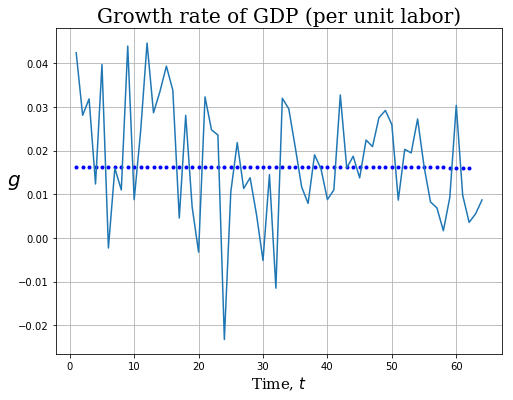

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

intensive_output = ces_model.evaluate_intensive_output(numeric_soln[:,1])
technology = ces_model.params['A0'] * np.exp(ces_model.params['g'] * numeric_soln[:,0])
output_per_capita = intensive_output * technology

ax.plot(numeric_soln[1:,0], np.diff(np.log(output_per_capita)),
        'bo', markersize=3.0)

Y = pwt.major_xs('USA').rgdpna.loc[:]
E = pwt.major_xs('USA').emp.loc[:]
ax.plot(np.log(( Y / E )).diff().values)

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel(r'$g$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Growth rate of GDP (per unit labor)', fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

In [63]:
np.diff?

In [64]:
(d.rgdpna / d.emp).pct_change()

AttributeError: 'function' object has no attribute 'rgdpna'

In [67]:
(Y.diff() / E.diff()).pct_change()

year
1950-01-01           NaN
1951-01-01           NaN
1952-01-01      0.582614
1953-01-01     -0.001715
1954-01-01     -0.901744
1955-01-01      6.731431
1956-01-01     -0.611630
1957-01-01      3.765566
1958-01-01     -0.904598
1959-01-01      6.485533
1960-01-01     -0.463657
1961-01-01     19.439066
1962-01-01     -0.864362
1963-01-01     -0.213369
1964-01-01     -0.159643
1965-01-01      0.110945
1966-01-01     -0.171994
1967-01-01     -0.423581
1968-01-01      1.040547
1969-01-01     -0.452953
1970-01-01     -0.704594
1971-01-01    889.447693
1972-01-01     -0.994062
1973-01-01     -0.073422
1974-01-01     -1.163447
1975-01-01     -1.551213
1976-01-01      9.955150
1977-01-01     -0.207313
1978-01-01      0.017655
1979-01-01     -0.095062
                 ...    
1985-01-01      0.189434
1986-01-01     -0.234994
1987-01-01     -0.128657
1988-01-01      0.446098
1989-01-01     -0.026060
1990-01-01      0.057832
1991-01-01     -0.966329
1992-01-01    260.037323
1993-01-01     -0.84

In [66]:
np.log(( Y / E )).diff()


year
1950-01-01         NaN
1951-01-01    0.042384
1952-01-01    0.028077
1953-01-01    0.031834
1954-01-01    0.012354
1955-01-01    0.039707
1956-01-01   -0.002302
1957-01-01    0.015954
1958-01-01    0.010991
1959-01-01    0.043925
1960-01-01    0.008749
1961-01-01    0.024399
1962-01-01    0.044619
1963-01-01    0.028657
1964-01-01    0.033521
1965-01-01    0.039330
1966-01-01    0.033822
1967-01-01    0.004559
1968-01-01    0.028069
1969-01-01    0.007092
1970-01-01   -0.003250
1971-01-01    0.032291
1972-01-01    0.024755
1973-01-01    0.023568
1974-01-01   -0.023272
1975-01-01    0.010519
1976-01-01    0.021831
1977-01-01    0.011312
1978-01-01    0.013786
1979-01-01    0.005270
                ...   
1985-01-01    0.020823
1986-01-01    0.011657
1987-01-01    0.007912
1988-01-01    0.019025
1989-01-01    0.015831
1990-01-01    0.008781
1991-01-01    0.011001
1992-01-01    0.032728
1993-01-01    0.016007
1994-01-01    0.018711
1995-01-01    0.013755
1996-01-01    0.022413
1997-0

In [68]:
# for China

# Add assertion error to evaluate solow_residual method@
result, params = maximize_likelihood(ces_model, pwt, 'CHN', bounds=(None, None),
                                     method='Nelder-Mead', sigma0=0.5, sigma_eps0=0.01)

In [69]:
result

 final_simplex: (array([[ 0.01875949,  0.01448191,  0.2576537 ,  0.32434538,  0.01790749,
         1.24902843,  0.02160863],
       [ 0.01875942,  0.01448379,  0.25764479,  0.32434711,  0.0179076 ,
         1.24900019,  0.02160769],
       [ 0.01876129,  0.01448412,  0.25764132,  0.32435145,  0.01790786,
         1.24896977,  0.02160962],
       [ 0.01876143,  0.01448335,  0.25766486,  0.3243426 ,  0.01790675,
         1.24904323,  0.0216114 ],
       [ 0.01876059,  0.01448307,  0.25765894,  0.32434623,  0.01790715,
         1.24902639,  0.02161005],
       [ 0.01875921,  0.01448164,  0.25765249,  0.32434443,  0.01790743,
         1.24903814,  0.02160825],
       [ 0.01875998,  0.01448185,  0.2576576 ,  0.32434775,  0.01790716,
         1.2490357 ,  0.02160945],
       [ 0.01875904,  0.01448154,  0.25764262,  0.32434361,  0.01790753,
         1.24903546,  0.0216076 ]]), array([-152.17773374, -152.17772812, -152.17771947, -152.17771798,
       -152.17770153, -152.1776997 , -152.17769517

In [70]:
ces_model.params = params

In [71]:
params

{'A0': 1862.2538,
 'K0': 1345059.5,
 'L0': 344.01831,
 'alpha': 0.32434538109809696,
 'delta': 0.017907490797456824,
 'g': 0.018759487745440485,
 'n': 0.014481909191303686,
 's': 0.25765369916831515,
 'sigma': 1.2490284256963204,
 'sigma_eps': 0.021608629377300039}

In [72]:
def _initial_condition(model):
    k0 = model.params['K0'] / (model.params['A0'] * model.params['L0'])
    return k0

# need to specify some initial conditions
t0, k0 = 0.0, _initial_condition(ces_model)
numeric_soln = ces_model.ivp.solve(t0, k0, T=62, integrator='dopri5')

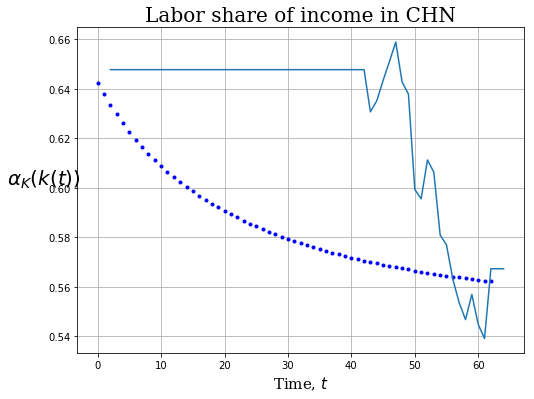

In [74]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

ax.plot(numeric_soln[:,0], 1 - ces_model.evaluate_output_elasticity(numeric_soln[:,1]),
        'bo', markersize=3.0)

ax.plot(pwt.major_xs('CHN').labsh.loc[:].values)

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel(r'$\alpha_K(k(t))$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Labor share of income in CHN', fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()

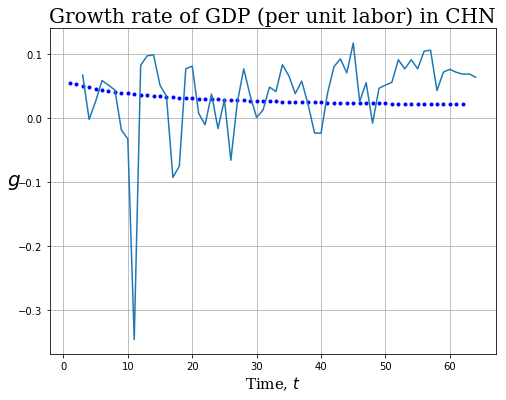

In [75]:
fig, ax = plt.subplots(1, 1, figsize=(8,6))

intensive_output = ces_model.evaluate_intensive_output(numeric_soln[:,1])
technology = ces_model.params['A0'] * np.exp(ces_model.params['g'] * numeric_soln[:,0])
output_per_capita = intensive_output * technology

ax.plot(numeric_soln[1:,0], np.diff(np.log(output_per_capita)),
        'bo', markersize=3.0)

Y = pwt.major_xs('CHN').rgdpna.loc[:]
E = pwt.major_xs('CHN').emp.loc[:]
ax.plot(np.log(( Y / E )).diff().values)

# axes, labels, title, etc
ax.set_xlabel('Time, $t$', fontsize=15, family='serif')
ax.set_ylabel(r'$g$', rotation='horizontal', fontsize=20, family='serif')
ax.set_title('Growth rate of GDP (per unit labor) in CHN', fontsize=20, family='serif')
ax.legend(loc=0, frameon=False, bbox_to_anchor=(1.0, 1.0))
ax.grid('on')

plt.show()